In [4]:
from IPython.display import Image

# ACRIS Data Description

## Introduction

### What is ACRIS?

The New York City Department of Finance's ACRIS, short for "Automated City Register Information System", is the document store of record for all building financial information and building landowner information in New York City. Every bank lien, bankruptcy, mortgage, vacate order, deed transfer, and real estate sale tax certificate is stored here, as are innumerable other documents, both in scanned PDF format and in terms of extracted financial information.

The ACRIS system is a basis of information for durable New York-based real estate tracking companies like [PropertyShark](http://www.propertyshark.com/mason/) et. al.

### How is it distributed?

ACRIS is distributed in two forms. The first format is that of an online [web portal](https://acrisweb.csc.nycnet/cp/). This web portal is designed for single queries&mdash;that is, it allows one to look up financial documents for one lot, for instance, or for one owner, or whatever the case may be.

From a data perspective this is always the most reliable source of ACRIS data. If you are using ACRIS data for something, but sure to spot-check a few BBLs against this system to make sure you are correct! However it is difficult to operationalize because this data would be very hard to scrape&mdash;the ACRIS portal implements an [anti- cross-site forgery token](https://en.wikipedia.org/wiki/Cross-site_request_forgery), so each query would have to hit the site twice, once at the main page and once per query of interest.

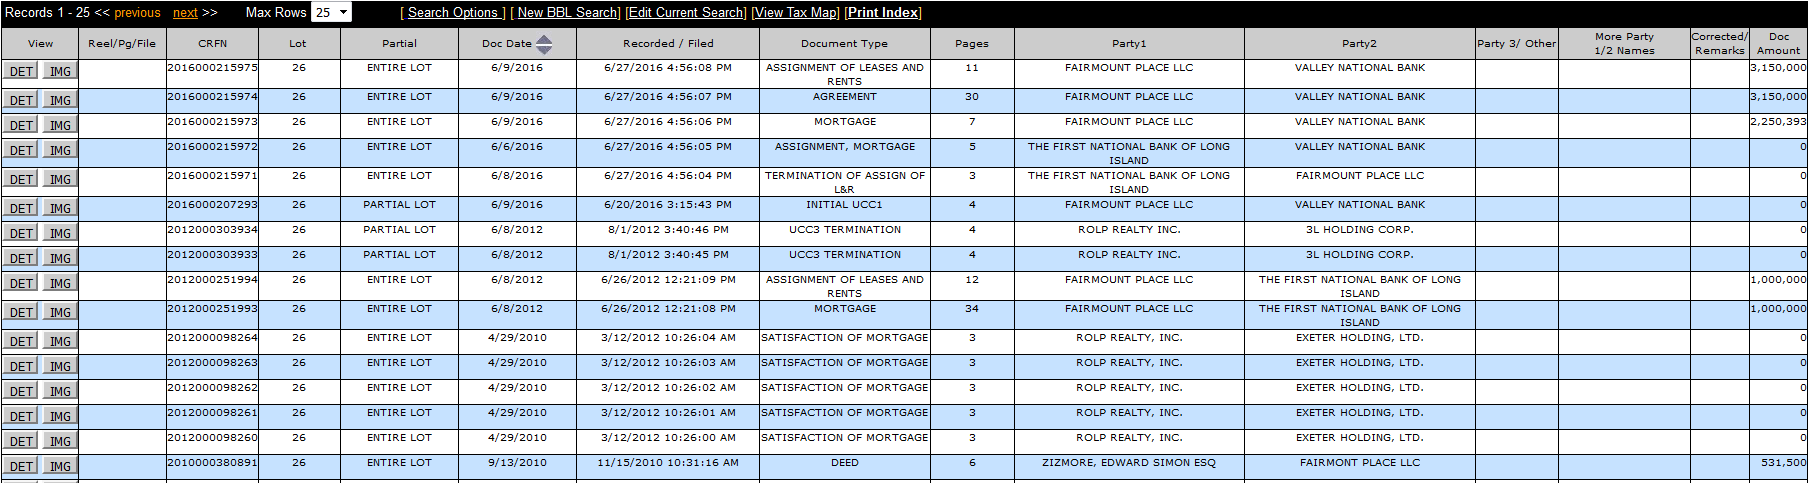

In [10]:
Image(filename='figures/ACRIS Web Interface.png')

That shouldn't be necessary anyway, because ACRIS is also provided on the Open Data Portal. However, due to the sheer size of the ACRIS dataset, which goes back reliably to 1965 or so, this dataset is provided in a federated format. There are fifteen datasets on the ACRIS portal: five containing property recordsets, five containing personal recordsets, and five containing code mappings (indices of one form or another for shorthand notations&mdash;for example the document control codes dataset explains that `MTGE` means `Mortgage Agreement`).

The fill brace of ACRIS data stores is available through a description document DoITT attached to all fifteen datasets, available [here](https://data.cityofnewyork.us/api/assets/75331466-3522-49D8-9049-119E1D4F0F9E?download=true) (if this link does not work, another copy is provided in, but that in that case this document might now be out of date).

Briefly:
* Master record &mdash; the core data; provides document IDs, types, dates, and financial values.
* Lot record &mdash; Contains basic information about individual lots associated with the documents. This data is more easily accessible through the `PLUTO` or `RPAD` datasets, however.
* Party record &mdash; the parties privy to the record in question. Necessary to get any meaningful historical record out of a building&mdash;who owned it when, and for how long.
* Cross-reference record
* Remarks record

Each of the non-trivial ACRIS datasets contains 10 to 40 million rows and weighs in at around 1 to 3 GB. Downloading a dataset on the 100 Gold Street wired internet, or indeed anywhere, requires several hours. Data replication on the operational side means that your computer will probably need over 8 GB of RAM (16 or more recommended) to fully open and work with one file, and definitely more than that to do so with two.

Since this is a Department of Finance dataset, all financial information is provided on the Borough-Block-Lot level. Data in provided by document&mdash;the unifying unique key is `{Document_Id, Borough, Block, Lot}` (yes&mdash;`Document_Id` alone is not sufficient!)

However, the online ACRIS portal has the huge problem that it is randomly missing data. A spot inspection of 15 buildings found that only 4 appeared to be complete, raising questions about how the open data is packaged and distributed. Use of ACRIS data in production would probably require conversations with DOF, DoITT, and Socrata on refreshing the data feed.

Another potential source of ACRIS data is DataBridge, which has a version of it that we have no studied too extensively but which appears to cut out in 2013.

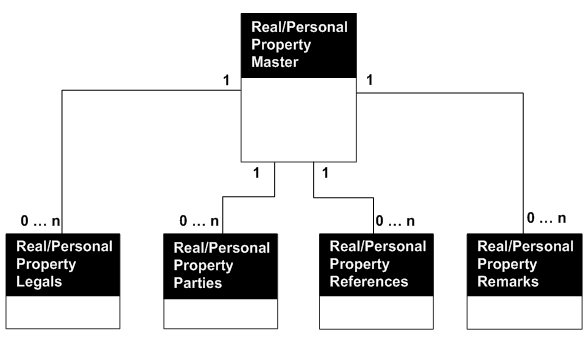

In [6]:
Image(filename='figures/DOF ACRIS Dataset.png')

## Contents

### Shape

The following plots briefly summarize the shape of the data present in ACRIS:

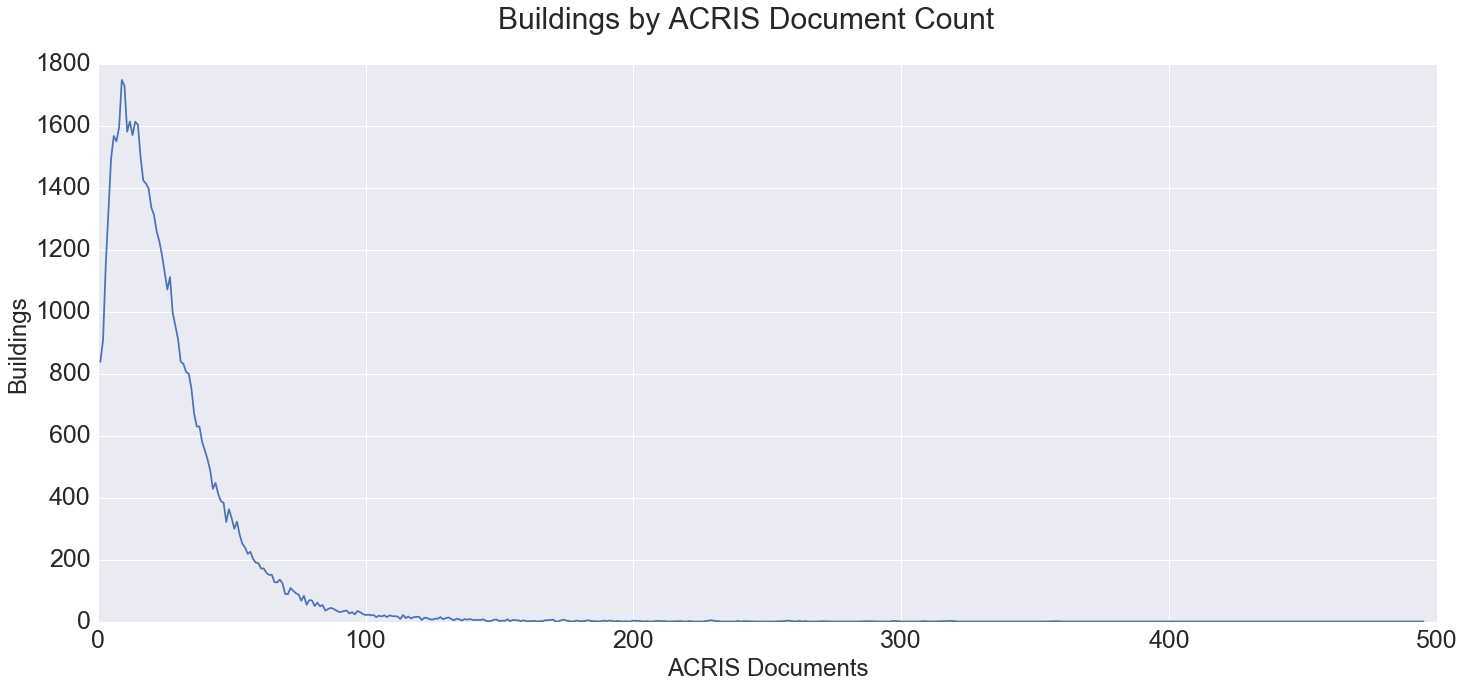

In [8]:
Image(filename='figures/ACRIS Buildings by Document Count.png')

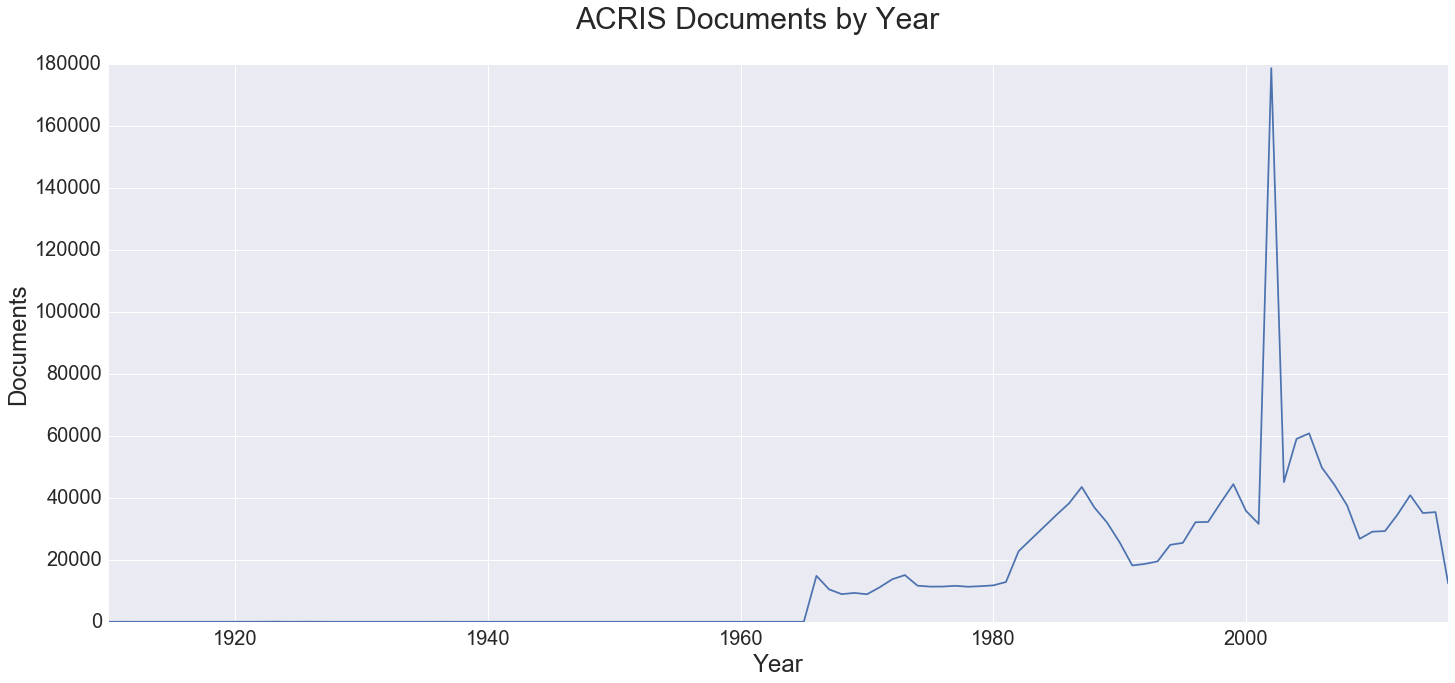

In [12]:
Image(filename='figures/ACRIS Documents by Year.png')

(**Note**: This is by year most recently modified; the 2002 spike comes from some sort of mass touch-up of old records which occurred that year.)

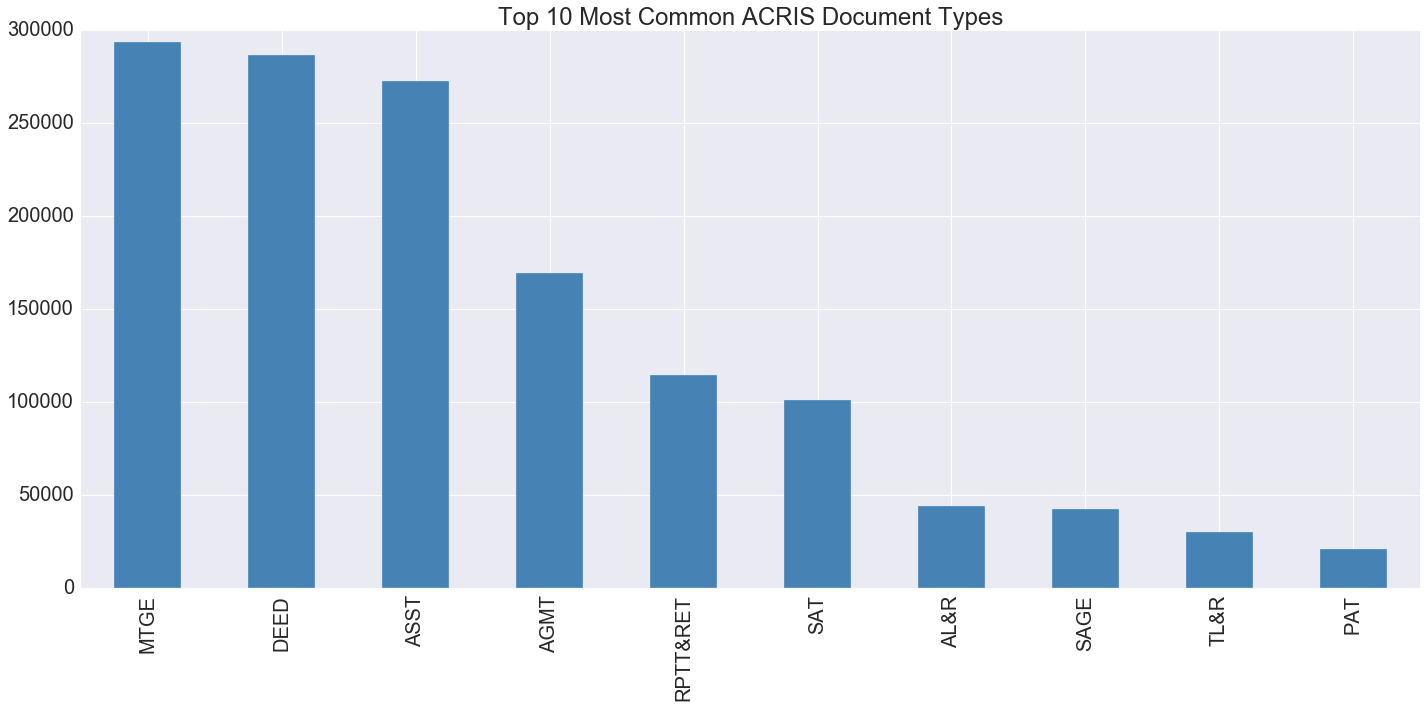

In [13]:
Image(filename='figures/ACRIS Document Types.png')

### Common Document Types

Some of the most common document types.

#### MTGE — Mortgage

A mortgage is a financial instrument that we're all very familiar with, in which a bank buys a building and makes you the owner of it, so long as you eventually pay back the loan you had to take out to make that a reality (with the bank making back on its investment through accrued interest).

Mortgages can be taken out on units. They can also be taken out on whole buildings. A building loan for a building of the size of interest for this study is considered a small commercial loan.

A mortgage may be partial value or it may cover the entire building or unit.

The face value of the mortgage goes to the building owner immediately.

Cash transactions, either in part and whole, are invisible to the city and don't appear in the dataset.

We also don't have any information on whether or not the mortgage is payed back.

#### DEED — Deed Transfer

A deed transfer occurs whenever there is a transfer of title, in this case, transfer of ownership of a building.

A deed transfer is not an unambigous valuation, however. Many sales occur for zero or small sums, especially when they are just title transfers amongst family members.
ASST — Mortgage Assignment Transaction

Banks often buy and sell mortgages to and from one another. This document indicates that this has occured (source).

#### AGMT — Mortgage Agreement

A mortgage agreement is an agreement between the mortgagee and the bank that in the event that the mortgagee cannot repay the loan the bank may repossess (foreclose) the home. This is known as a legal lien.

Again, this has no real meaning for our use case.
RPTT&RET — Real Property Transfer Tax and Real Estate Tax

RPTT is a city tax on real property transfers. RET is a state tax on the same. The state tax kicks in at $500, the city tax at \$25,000.

The fact that the lower value triggers at such a low value means that we can use these entries as a reliable proxy for the sale of a residential unit.

The state tax rate is 0.4%, except in the case of an additional 1% "mansion tax" for properties over 1 million dollars in value, in which case the state tax rate goes to 1.4%. The city tax rate is, for residential transfers, 1% for less than $500,000 of property and 1.425\% for more.

This makes for a 1.4\% bottom transfer tax rate. This means that we can use RPTT&RET to reverse engineer a lower bound for the value of a transfer whose value is otherwise unknown by taking the dollar amount assigned to this record and dividing by .014.

#### SAT — Satisfaction of Mortgage

This document notarizes that a mortgage has been fully paid (source).

For our use case, such a document is important to note if it is on the part of the owner, indicating that they have paid back the amount previously due for a loan, and not useful at all if it is on the part of a unit owner, in which case it carries no meaning.
AL&R — Assignment of Leases and Rents

Short for "assignment of leases and rents", this document ensures that should the property owner default on their loan the bank will be entitled to any income they generate from leases and rents on the property. The dollar amount is the collatoral (source).

#### SAGE — Sundry Agreement

Any general agreement which does not fit in any of the other buckets.

Not useful for us.

#### TL&R — Termination of Assignment of Leases and Rents

Terminates the collatoral agreement put on by the bank in a AL&R.
PAT — Power of Attorney

Gives the power to buy and sell real estate in your name to someone else.

These ten most common document types cover 90% of all documents on the record.

There are 123 record types total (really more), so of the remainder we will focus only on the most interesting ones (since many of these top ten turned out to have no meaning for our purposes).

#### BRUP — UCC3 Bankruptcy

The mortagee declares bankruptcy. All is lost.

#### COPT — Condemnation Proceedings

Interestingly enough this is the technical name for the exercise of eminent domain.

#### LEAS — Lease

Oddly very rare. We believe this is because the city does not truly regular leases, and they are included as documents only under certain circumstances.

#### VAC — Vacate Order

Public-safety vacate order of an unsafe building (source).

#### M&CON — Mortgage and Consolidation

When a mortgage is consolidated with certain other financial obligations, like credit card debt.

### Party Record Data Snippet

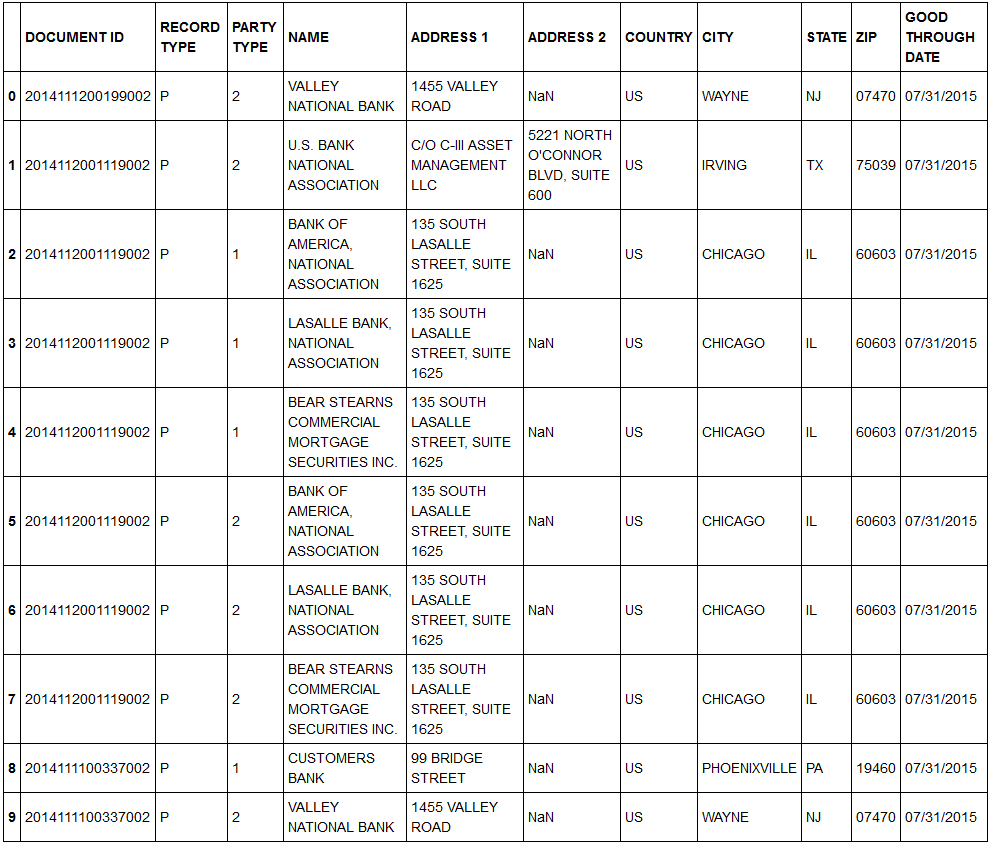

In [14]:
Image("figures/Party Record Selection.png")

In term of combining multiple datasets, most of the value-add from the ACRIS dataset can be found in combining the document party dataset (above) with the master record dataset (not pictured) into a single unified file. This can be done using the `{Document_Id, Borough, Block, Lot}` key mentioned earlier.

### More on `Document_Id` non-uniqueness

A document can be associated with multiple borough-block-lot -identified buildings.

For instance, from examining the record I found that the following two buildings are both linked to one particular document, the one with the document id `2010091300452003`:

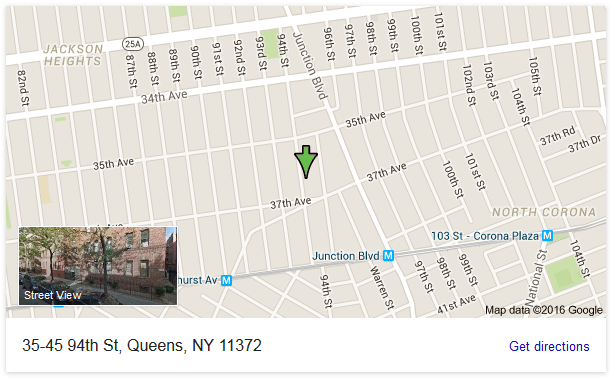

In [15]:
Image("figures/2016-07-07 11_41_40-35-45 94 STREET - Google Search.png")

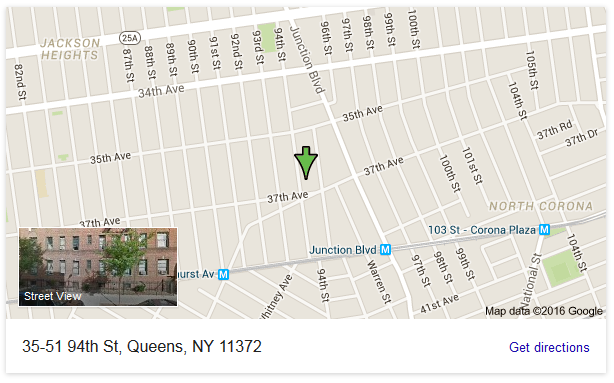

In [16]:
Image("figures/2016-07-07 11_44_45-35-51 94 STREET - Google Search.png")

**This is the same building**, just split across two different BBLs, in the arbitrary way that building BBLs sometimes do.

Hence why you can't use `Document_Id` as a unique key, and have to be careful with how you map values for *multiple* buildings to values for *singular* ones.

### Case Study

Try the web portal out! `27 WEST 67 STREET`, below, makes for a good case study.

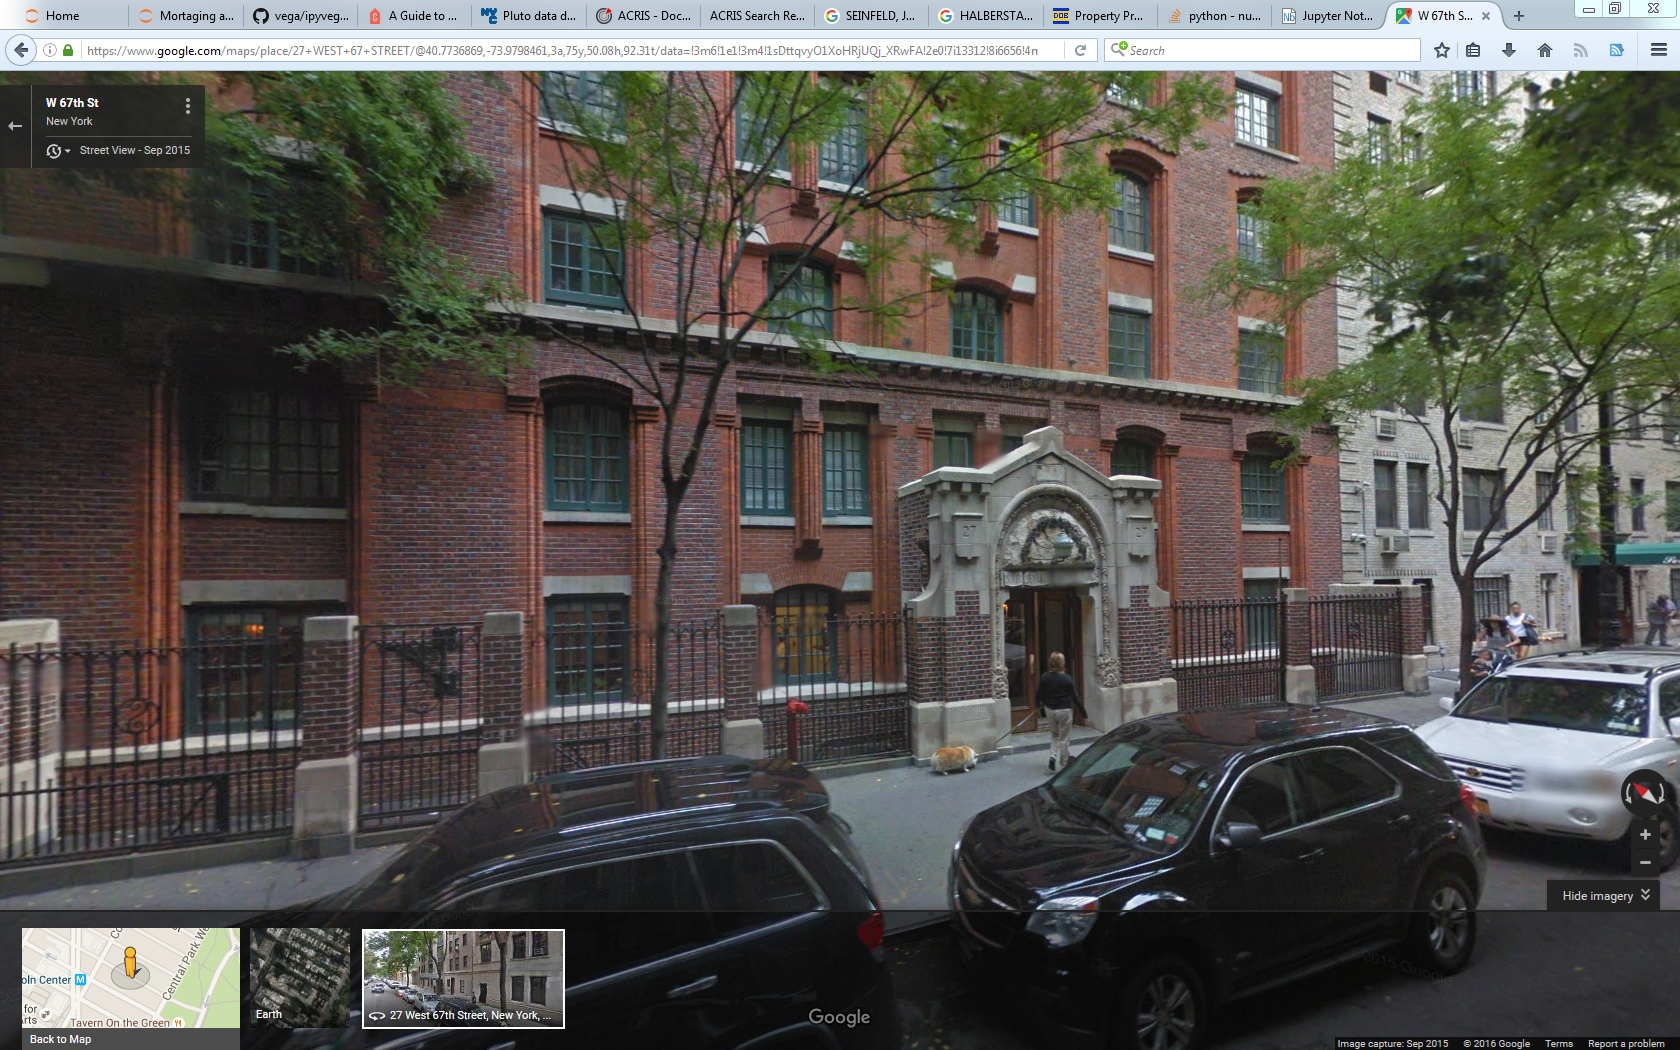

In [17]:
Image("figures/West 67 Street.png")